# Metric Learning

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from data_utils import cub2011
from data_utils import stanford_cars
from collections import OrderedDict
from copy import deepcopy

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
IMAGE_SIZE = 224

## Download data

### Download model
We are basing our experiments on pre-trained resnet50

In [3]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
preprocess_transforms = weights.transforms()

In [22]:
net = torchvision.models.resnet50(pretrained=True)

/home/richard/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/richard/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/richard/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Download datasets
We are downloading two benchmark datasets:
* Stanford-Cars (CARS 196) - https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
* CUB 200 2011 - https://www.kaggle.com/datasets/wenewone/cub2002011

In [9]:
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 32

In [10]:
cars_trainset = stanford_cars.download_cars('./data', train=True, download=True, transforms=train_transform)
cars_testset = stanford_cars.download_cars('./data', train=True, download=False, transforms=transform)

cub_trainset = cub2011.download_cub('./data', train=True, download=True, transforms=train_transform)
cub_testset = cub2011.download_cub('./data', train=False, download=False, transforms=transform)

Skipping, found downloaded files in "./data/stanford-car-dataset-by-classes-folder" (use force=True to force download)
folder already exits in given location: ./data/stanford-car-dataset-by-classes-folder
Skipping, found downloaded files in "./data/cub2002011" (use force=True to force download)
folder already exits in given location: ./data/cub2002011


In [11]:
cars_trainloader = torch.utils.data.DataLoader(cars_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cars_testloader = torch.utils.data.DataLoader(cars_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)
cub_trainloader = torch.utils.data.DataLoader(cub_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cub_testloader = torch.utils.data.DataLoader(cub_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)

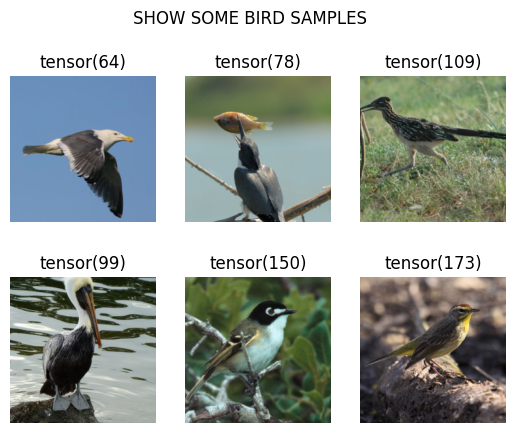

In [12]:
images, labels = next(iter(cub_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME BIRD SAMPLES')

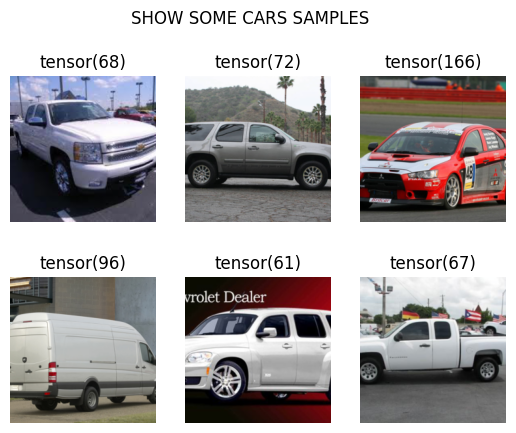

In [13]:
images, labels = next(iter(cars_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME CARS SAMPLES')

## Network

### Prepare pre-trained ResNet50

In [23]:
# freezing resnet50 params
for param in net.parameters():
    param.requires_grad = False

### Customizable representation-learning module

In [26]:
def get_model(frozen_model, frozen_model_ending=2048, representation_dim=10):
    classifier = nn.Sequential(OrderedDict([
        ('fc0', nn.Linear(frozen_model_ending, 256)),
        ('norm0', nn.BatchNorm1d(256)),
        ('relu0', nn.ReLU(inplace=True)),
        ('fc1', nn.Linear(256, representation_dim))
    ]))
    x = deepcopy(frozen_model)
    x.representation = classifier
    return x

In [27]:
model = get_model(net, 10)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 